In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch as tr
from torch import nn
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt

%matplotlib inline

In [262]:
from impl.arch import *
from impl.rendering import *
from impl.data_source import *
from impl.misc import *

In [57]:
model = SeparatedHeadsNerfModel(config=ModelConfig(
    hidden_size=128,
    embed_num_pos=6,
    embed_num_dir=6,
))

In [58]:
def predict(pose: torch.Tensor):
    return nf_render_pose(
        model,
        height,
        width,
        focal_length,
        pose=pose,
        thresh_near=2,
        thresh_far=6,
        num_samples_per_ray=32,
        chunk_size=8096,
    )

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [113]:
# Train
for i in range(1000):
    idx = torch.randint(images.shape[0], (1,)).item()
    # idx = i % images.shape[0]
    target_pose = poses[idx]
    # (H, W, 3)
    target_image = images[idx]
    
    # (H, W, 3)
    image_predicted = predict(target_pose)

    loss = F.mse_loss(image_predicted, target_image)

    if i % 100 == 0:
        print(f"{i}: {loss.item()}") 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Done")

0: 0.001995414961129427
100: 0.0017038699006661773
200: 0.0012751311296597123
300: 0.0031727615278214216
400: 0.0018610317492857575
500: 0.0021134568378329277
600: 0.0012752397451549768
700: 0.0008220204035751522
800: 0.0022676975931972265
900: 0.002400435274466872
Done


Showing index 17


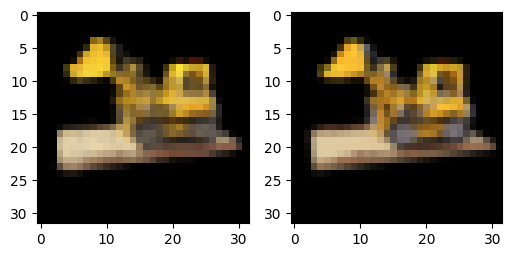

In [263]:
# test_idx = torch.randint(images.shape[0], (1,)).item()
test_idx = 17

print(f"Showing index {test_idx}")
plt.figure(figsize=(6,3))

predicted = predict(poses[test_idx]).detach()
plt.subplot(1,2,1)
plt.imshow(predicted)

plt.subplot(1,2,2)
plt.imshow(images[test_idx])

theta=109.37007904052734, phi=156.30015563964844


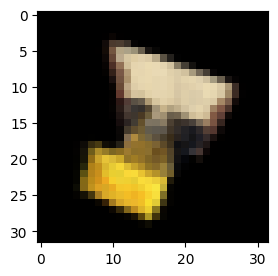

In [265]:
# View a truly random pose, sampled from a sphere around the object
plt.figure(figsize=(3,3))
plt.imshow(predict(random_spherical_pose()).detach())

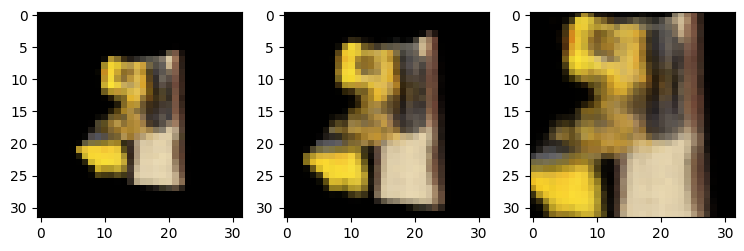

In [266]:
# View the same pose with varying distance of camera from the object
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(predict(create_pose(radius=5, theta=10, phi=50)).detach())

plt.subplot(1,3,2)
plt.imshow(predict(create_pose(radius=4, theta=10, phi=50)).detach())

plt.subplot(1,3,3)
plt.imshow(predict(create_pose(radius=3, theta=10, phi=50)).detach())

In [118]:
# torch.save({'model_state': model.state_dict()},'checkpoints/multihead_001.chk')

In [23]:
# checkpoint = torch.load('checkpoints/001.chk')
# model.load_state_dict(checkpoint['model_state'])